# Data Augmentation

In [329]:
import os
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from tqdm import tqdm
import geopandas
from geodatasets import get_path
import matplotlib.pyplot as plt

FILE_PATH = os.path.abspath('')

DATA_DIR = FILE_PATH.split('src')[0] + 'data'

## Schools

In [59]:
# Load the school data
school_data = pd.read_csv(os.path.join(DATA_DIR, 'CSV', 'school_locations.csv'))

In [60]:
# Convert dates
school_data['open_date'] = pd.to_datetime(school_data['open_date'], errors='coerce')
school_data.dropna(subset=['open_date', 'LONGITUDE', 'LATITUDE'], inplace=True)

# Filter closed schools
school_data['Status_descriptions'] = school_data['Status_descriptions'].fillna('Open')
school_data = school_data[school_data['Status_descriptions'] == 'Open']
school_data.drop(columns=['Status_descriptions'], inplace=True)
school_data = school_data[['open_date', 'LONGITUDE', 'LATITUDE', 'Location_Category_Description']]

In [106]:
path_to_data = get_path("nybb")
boroughs = geopandas.read_file(path_to_data).to_crs(epsg=4326)

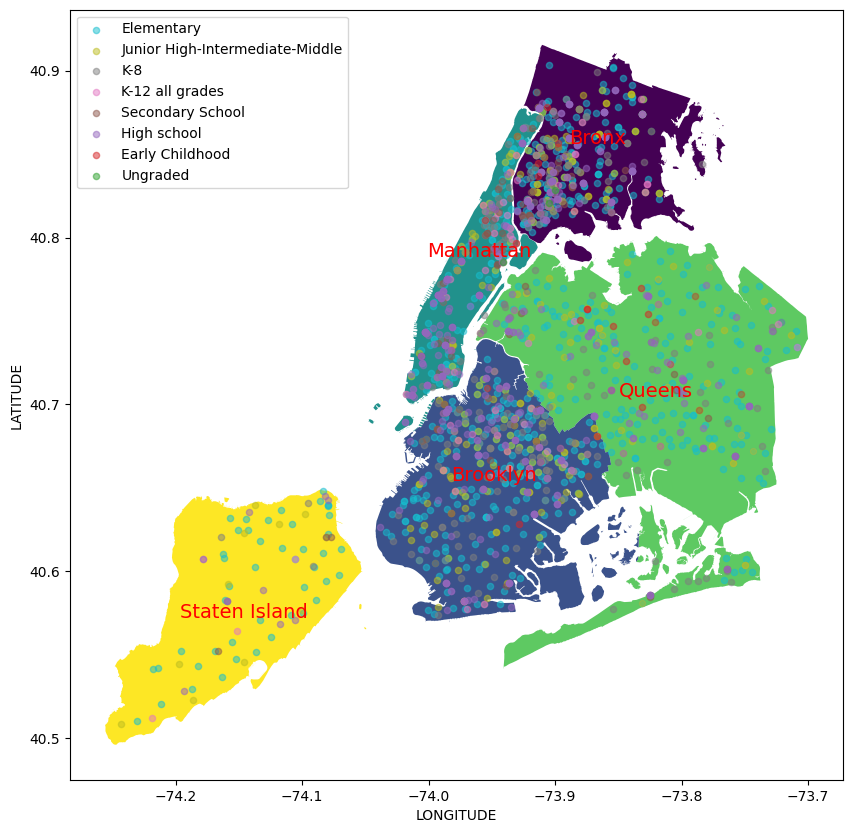

In [148]:
fig, ax = plt.subplots(figsize=(10, 10))
boroughs.plot('BoroName', legend=True, ax=ax, cmap='viridis')

for i, row in boroughs.iterrows():
    ax.annotate(row['BoroName'], xy=row['geometry'].representative_point().coords[0], ha='center', color='red', fontsize=14)


colors = list(plt.get_cmap('tab10').colors)
for category in school_data['Location_Category_Description'].unique():
    school_data[school_data['Location_Category_Description'] == category].plot.scatter(x='LONGITUDE', y='LATITUDE', alpha=0.5, ax=ax, color=colors.pop(), label=category)

ax.legend(loc='upper left')
plt.show()

In [117]:
school_data['Borough'] = None

for i, row in boroughs.iterrows():
    geom = boroughs.at[i, 'geometry']
    mask = geom.contains(geopandas.points_from_xy(school_data['LONGITUDE'], school_data['LATITUDE']))
    school_data.loc[mask, 'Borough'] = boroughs.at[i, 'BoroName']

In [165]:
# school opening times based on 
# https://www.aaastateofplay.com/the-average-school-start-times-in-every-state/ 
# are approx. at 8:00 am for NY

# school durations based on
# https://nces.ed.gov/programs/statereform/tab5_14.asp
# rounded down as we are using hourly data

five_hour = [
    'Elementary'
    'Junior High-Intermediate-Middle',
    'K-8',
    'K-12 all grades',
    'Early Childhood',
    'Ungraded'
]
six_hour = [
    'High school',
    'Secondary School',
    'High School',
]

In [235]:
def get_schools_hourly_df(school_data, borough):
    # Generate hourly datetime range from 2013 to 2024
    hourly_dates = pd.date_range(start='2013-01-01', end='2024-12-31 23:00:00', freq='h')
    hourly_df = pd.DataFrame(hourly_dates, columns=['datetime'])

    school_data = school_data[school_data['Borough'] == borough]
    hourly_df['open_schools'] = 0
    school_months = hourly_df['datetime'].dt.month.isin([9, 10, 11, 12, 1, 2, 3, 4, 5, 6])
    for school_type in five_hour:
        open_schools = len(school_data[school_data['Location_Category_Description'] == school_type])
        hourly_df.loc[school_months & (hourly_df['datetime'].dt.hour >= 8) & (hourly_df['datetime'].dt.hour < 13), 'open_schools'] += open_schools
        

    for school_type in six_hour:
        open_schools = len(school_data[school_data['Location_Category_Description'] == school_type])
        hourly_df.loc[school_months & (hourly_df['datetime'].dt.hour >= 8) & (hourly_df['datetime'].dt.hour < 14), 'open_schools'] += open_schools

    return hourly_df

In [182]:
for borough in school_data['Borough'].unique():
    print(f'Processing {borough}')
    hourly_df = get_schools_hourly_df(school_data, borough)
    hourly_df.to_csv(os.path.join(DATA_DIR, 'CSV', f'{borough}_school_openings.csv'), index=False)

Processing Brooklyn
Processing Manhattan
Processing Bronx
Processing Queens
Processing Staten Island


In [240]:
# Generate hourly datetime range from 2013 to 2024
hourly_dates = pd.date_range(start='2013-01-01', end='2024-12-31 23:00:00', freq='h')
hourly_df = pd.DataFrame(hourly_dates, columns=['datetime'])

cal=USFederalHolidayCalendar()

In [241]:
hourly_df['holiday'] = False
for rule in cal.rules:
    holidays_filter = (hourly_df['datetime'].dt.month == rule.month) & (hourly_df['datetime'].dt.day == rule.day)
    hourly_df.loc[holidays_filter, 'holiday'] = True

## Businesses

In [298]:
business_data = pd.read_csv(os.path.join(DATA_DIR, 'CSV', 'business_locations.csv'), low_memory=False)

# Convert License Creation Date and License Expiration Date to datetime
business_data['License Creation Date'] = pd.to_datetime(business_data['License Creation Date'], errors='coerce')
business_data['License Expiration Date'] = pd.to_datetime(business_data['License Expiration Date'], errors='coerce')

# Filter for relevant columns
business_data = business_data[['License Expiration Date', 'License Status', 'License Creation Date', 'Industry', 'Location']]

# Create LATITUDE and LONGITUDE columns from tuple location
business_data.dropna(subset='Location', inplace=True)
business_data['Location'] = business_data['Location'].str.replace('(', '').str.replace(')', '')
business_data['LATITUDE'] = business_data['Location'].apply(lambda x: float(x.split(',')[0]))
business_data['LONGITUDE'] = business_data['Location'].apply(lambda x: float(x.split(',')[1]))
# business_data.drop(columns=['Location'], inplace=True)

In [299]:
business_data = business_data.loc[business_data['License Expiration Date'] > pd.Timestamp('2013-01-01')]

In [336]:
business_data = business_data.sample(frac=0.1) # TODO: remove subsampling

In [340]:
business_data['Borough'] = None

for i, row in boroughs.iterrows():
    print(boroughs.at[i, 'BoroName'])
    geom = boroughs.at[i, 'geometry']
    mask = geom.contains(geopandas.points_from_xy(business_data.LONGITUDE, business_data.LATITUDE))
    business_data.loc[mask, 'Borough'] = boroughs.at[i, 'BoroName']

Staten Island
Queens
Brooklyn
Manhattan
Bronx


In [353]:
industry_hours = {
    "Laundries": (7, 21),
    "Sidewalk Cafe": (8, 22),
    "Secondhand Dealer - General": (10, 18),
    "Electronic & Appliance Service": (9, 19),
    "Employment Agency": (9, 17),
    "Home Improvement Contractor": (8, 18),
    "Tobacco Retail Dealer": (9, 21),
    "Electronic Cigarette Dealer": (10, 20),
    "Newsstand": (6, 21),
    "Garage": (0, 24),
    "Electronics Store": (10, 20),
    "Stoop Line Stand": (7, 20),
    "Tow Truck Company": (0, 24),
    "Secondhand Dealer - Auto": (9, 19),
    "Garage and Parking Lot": (0, 24),
    "Bingo Game Operator": (18, 23),
    "Pawnbroker": (9, 18),
    "Process Serving Agency": (9, 17),
    "Car Wash": (8, 20),
    "Dealer In Products": (10, 18),
    "Laundry": (7, 21),
    "Parking Lot": (0, 24),
    "Laundry Jobber": (7, 17),
    "Construction Labor Provider": (7, 17),
    "Pedicab Business": (10, 18),
    "Special Sale": (10, 18),
    "Third Party Food Delivery": (0, 24),
    "Debt Collection Agency": (9, 17),
    "Scrap Metal Processor": (8, 17),
    "Catering Establishment": (9, 21),
    "Tow Truck Exemption": (0, 24),
    "Ticket Seller Business": (10, 18),
    "Horse Drawn Cab Owner": (9, 17),
    "Auction House Premises": (10, 18),
    "Amusement Device Temporary": (10, 22),
    "Games of Chance": (10, 22),
    "Storage Warehouse": (8, 17),
    "Amusement Device Portable": (10, 22),
    "Cabaret": (19, 4),
    "Booting Company": (8, 20),
    "Commercial Lessor": (9, 17),
    "Gaming Cafe": (10, 22),
    "Amusement Arcade": (10, 22),
    "Amusement Device Permanent": (10, 22),
    "Pool or Billiard Room": (12, 2),
    "Scale Dealer Repairer": (9, 17),
    "Sightseeing Bus": (8, 20),
    "General Vendor Distributor": (10, 18),
    "Secondhand Dealer - Firearms": (10, 18)
}

industry_weekend_service = {
    "Laundries": True,
    "Sidewalk Cafe": True,
    "Secondhand Dealer - General": True,
    "Electronic & Appliance Service": True,
    "Employment Agency": False,
    "Home Improvement Contractor": True,
    "Tobacco Retail Dealer": True,
    "Electronic Cigarette Dealer": True,
    "Newsstand": True,
    "Garage": True,
    "Electronics Store": True,
    "Stoop Line Stand": True,
    "Tow Truck Company": True,
    "Secondhand Dealer - Auto": True,
    "Garage and Parking Lot": True,
    "Bingo Game Operator": True,
    "Pawnbroker": True,
    "Process Serving Agency": False,
    "Car Wash": True,
    "Dealer In Products": True,
    "Laundry": True,
    "Parking Lot": True,
    "Laundry Jobber": True,
    "Construction Labor Provider": False,
    "Pedicab Business": True,
    "Special Sale": True,
    "Third Party Food Delivery": True,
    "Debt Collection Agency": False,
    "Scrap Metal Processor": False,
    "Catering Establishment": True,
    "Tow Truck Exemption": True,
    "Ticket Seller Business": True,
    "Horse Drawn Cab Owner": False,
    "Auction House Premises": False,
    "Amusement Device Temporary": True,
    "Games of Chance": True,
    "Storage Warehouse": False,
    "Amusement Device Portable": True,
    "Cabaret": True,
    "Booting Company": True,
    "Commercial Lessor": False,
    "Gaming Cafe": True,
    "Amusement Arcade": True,
    "Amusement Device Permanent": True,
    "Pool or Billiard Room": True,
    "Scale Dealer Repairer": False,
    "Sightseeing Bus": True,
    "General Vendor Distributor": True,
    "Secondhand Dealer - Firearms": False
}

In [358]:
def get_business_hourly_df(business_data, borough):
    # Generate hourly datetime range from 2013 to 2024
    hourly_dates = pd.date_range(start='2013-01-01', end='2024-12-31 23:00:00', freq='h')
    hourly_df = pd.DataFrame(hourly_dates, columns=['datetime'])

    business_data = business_data[business_data['Borough'] == borough]

    hourly_df['open_businesses'] = 0

    # for index, row in tqdm(hourly_df.iterrows(), total=hourly_df.shape[0]):
    #     businesses = business_data[(business_data['License Creation Date'] < row['datetime']) & (business_data['License Expiration Date'] > row['datetime'])]
    #     for industry, hours in industry_hours.items():
    #         if row.datetime.hour < hours[0] or row.datetime.hour >= hours[1]:
    #             continue
    #         else:
    #             open_businesses = len(businesses[businesses['Industry'] == industry])
    #             hourly_df.at[index, 'open_businesses'] += open_businesses
    
    pbar = tqdm(total=business_data.shape[0], desc='Processing businesses')
    for industry, hours in industry_hours.items():
        industry_filter = hourly_df['datetime'].dt.hour.isin(range(hours[0], hours[1]+1))
        if not industry_weekend_service[industry]:
            industry_filter = industry_filter  & hourly_df['datetime'].dt.weekday.isin(range(0, 5))
        businesses = business_data[business_data['Industry'] == industry]
        for index, row in businesses.iterrows():
            hourly_df.loc[industry_filter & (hourly_df['datetime'] >= row['License Creation Date']) & (hourly_df['datetime'] <= row['License Expiration Date']), 'open_businesses'] += 1
            pbar.update(1)
    pbar.close()
    return hourly_df

In [359]:
for borough in business_data['Borough'].unique():
    if borough is None:
        continue
    print(f'Processing {borough}')
    hourly_df = get_business_hourly_df(business_data, borough)
    hourly_df.to_csv(os.path.join(DATA_DIR, 'CSV', f'{borough}_business_openings.csv'), index=False)

Processing Brooklyn


Processing businesses: 100%|██████████| 2917/2917 [00:07<00:00, 398.60it/s]


Processing Queens


Processing businesses: 100%|██████████| 2790/2790 [00:06<00:00, 404.43it/s]


Processing Bronx


Processing businesses: 100%|██████████| 1497/1497 [00:03<00:00, 395.90it/s]


Processing Manhattan


Processing businesses: 100%|██████████| 2433/2433 [00:06<00:00, 398.79it/s]


Processing Staten Island


Processing businesses: 100%|██████████| 594/594 [00:01<00:00, 356.53it/s]


## Events

In [377]:
event_data = pd.read_csv(os.path.join(DATA_DIR, 'CSV', 'events.csv'))

# Convert Start Date/Time and End Date/Time to datetime
event_data['Start Date/Time'] = pd.to_datetime(event_data['Start Date/Time'], errors='coerce')
event_data['End Date/Time'] = pd.to_datetime(event_data['End Date/Time'], errors='coerce')

C:\Users\valte\AppData\Local\Temp\ipykernel_4692\282717625.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  event_data['Start Date/Time'] = pd.to_datetime(event_data['Start Date/Time'], errors='coerce')
C:\Users\valte\AppData\Local\Temp\ipykernel_4692\282717625.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  event_data['End Date/Time'] = pd.to_datetime(event_data['End Date/Time'], errors='coerce')


In [380]:
event_data = event_data[['Start Date/Time', 'End Date/Time', 'Event Type', 'Street Closure Type', 'Event Borough']]

In [391]:
def get_events_hourly_df(event_data, borough):
    # Generate hourly datetime range from 2013 to 2024
    hourly_dates = pd.date_range(start='2013-01-01', end='2024-12-31 23:00:00', freq='h')
    hourly_df = pd.DataFrame(hourly_dates, columns=['datetime'])

    event_data = event_data[event_data['Event Borough'] == borough]

    hourly_df['num_events'] = 0
    hourly_df['num_constructions'] = 0
    hourly_df['num_street_closures'] = 0

    for index, row in tqdm(event_data.iterrows(), total=event_data.shape[0]):
        start = row['Start Date/Time']
        end = row['End Date/Time']
        mask = (hourly_df['datetime'] >= start) & (hourly_df['datetime'] <= end)
        hourly_df.loc[mask, 'num_events'] += 1
        if row['Event Type'] == 'Construction':
            hourly_df.loc[mask, 'num_constructions'] += 1
        if row['Street Closure Type'] is not None:
            hourly_df.loc[mask, 'num_street_closures'] += 1

    return hourly_df

In [392]:
for borough in event_data['Event Borough'].unique():
    print(f'Processing {borough}')
    hourly_df = get_events_hourly_df(event_data, borough)
    hourly_df.to_csv(os.path.join(DATA_DIR, 'CSV', f'{borough}_events.csv'), index=False)

Processing Queens


100%|██████████| 6869/6869 [00:22<00:00, 305.07it/s]


Processing Staten Island


100%|██████████| 1392/1392 [00:04<00:00, 296.11it/s]


Processing Brooklyn


100%|██████████| 7728/7728 [00:26<00:00, 296.92it/s]


Processing Bronx


100%|██████████| 4008/4008 [00:14<00:00, 283.44it/s]


Processing Manhattan


100%|██████████| 9269/9269 [00:32<00:00, 281.09it/s]


## Landmarks

In [432]:
landmark_data = pd.read_csv(os.path.join(DATA_DIR, 'CSV', 'landmarks.csv'))
landmark_data.dropna(subset=['Borough'], inplace=True)
landmark_data = landmark_data.drop_duplicates(subset=['OBJECTID'])
landmark_data = landmark_data[['Shape_Leng', 'Shape_Area', 'Borough']]

In [433]:
boroughs_map = {
    'SI': 'Staten Island',
    'QN': 'Queens',
    'MN': 'Manhattan',
    'BK': 'Brooklyn',
    'BX': 'Bronx'
}

landmark_data.Borough = landmark_data.Borough.map(boroughs_map)

In [437]:
for borough in landmark_data['Borough'].unique():
    print(f'Processing {borough}')
    hourly_dates = pd.date_range(start='2013-01-01', end='2024-12-31 23:00:00', freq='h')
    hourly_df = pd.DataFrame(hourly_dates, columns=['datetime'])

    landmarks = landmark_data[landmark_data['Borough'] == borough]
    borough_area = boroughs[boroughs['BoroName'] == borough].Shape_Area.values[0]
    total_landmark_area = landmarks.Shape_Area.sum()
    hourly_df['landmark_density'] = total_landmark_area / borough_area
    hourly_df['total_landmark_length'] = landmarks.Shape_Leng.sum()
    hourly_df['total_landmarks'] = len(landmarks)
    hourly_df.to_csv(os.path.join(DATA_DIR, 'CSV', f'{borough}_landmarks.csv'), index=False)

Processing Staten Island
Processing Queens
Processing Manhattan
Processing Brooklyn
Processing Bronx


# Weather

In [ ]:
"https://api.open-meteo.com/v1/forecast?latitude=52.52&longitude=13.41"
"&start_date=2021-01-01&end_date=2021-12-31"
"&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m"